# Parte 2. Calculos en vecindades

En la primera parte del taller trabajamos los datos para calcular las variables que nos interesan y agruparlas por AGEB. Ahora, en esta segunda parte, vamos a partir de los datos ya procesados y vamos a realizar algunos cálculos a partir de los valores en los polígonos vecinos.

El primer paso es _encapsular_  el preproceso de los datos en una función, de esta manera podemos ejecutar todo el _flujo_ en una celda en este Notebook. En el archivo `preproceso.py` de esta carpeta pueden ver la función que realiza todo el trabajo.

Para importar la función aquí, hacemos uso de la estructura de _paquetes_ (packages) de Python: siempre que una carpeta contenga un archivo con el nombre `__init__.py`, esa carpeta se convierte automáticamente en un paquete y permite importar diréctamente todas las funciones (o clases) definidas en los archivos que contiene.

En la siguiente celda realizamos todo el trabajo de preprocesamiento

**Nota 1:** la declaración `pd.options.mode.chained_assignment = None` sirve para suprimir una advertencia de Pandas sobre la forma en la que asignamos valores a nuevas columnas, en este caso (y en muchos otros), esa advertencia es espúrea, sin embargo, no está de más que lean [esto](http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy)

**Nota 2:** si se fijan, en el preproceso removimos algunas filas, por lo que el índice del DataFrame no es consecutivo, esto va a ser importante más adelante, por lo que nos conviene _resetear_ el índice para que se vuelva a calcular como un consecutivo

In [30]:
import pandas as pd
import geopandas as gpd
from preproceso import preprocesa
pd.options.mode.chained_assignment = None

denue = gpd.read_file("datos/DENUE_INEGI_09_.shp")
agebs = gpd.read_file("datos/ageb_urb.shp")
usos_suelo = preprocesa(denue, agebs)
usos_suelo.reset_index(drop=True, inplace=True)
usos_suelo.head()

si


,CVEGEO,geometry,clase_comercio,clase_ocio,clase_oficinas
0,0900200010010,"POLYGON ((2792673.308524352 837911.4750908648,...",68.0,24.0,6.0
1,0900200010025,"POLYGON ((2793350.822773742 837765.3497706538,...",27.0,11.0,0.0
2,090020001003A,"POLYGON ((2792311.17880615 837633.5167797694, ...",44.0,11.0,2.0
3,0900200010044,"POLYGON ((2792448.206535 837485.6465441301, 27...",38.0,7.0,0.0
4,0900200010097,"POLYGON ((2792415.238538118 836846.39013781, 2...",27.0,12.0,1.0


Como pueden ver, en la variable usos_suelo tenemos ya calculadas todas nuestras variables de interés, ahora lo que necesitamos es, para cada fila de nuestro GeoDataFrame, saber cuáles son los polígnos vecinos.

Para esto, vamos a utilizar la librería [PySal](http://pysal.readthedocs.io/en/latest/index.html), que provee un conjunto de métodos de análisis espacial. En particular, nos interesa la funcionalidad de crear matrices de _pesos_ espaciales.

PySal está desarrollado para trabajar en conjunto con GeoPandas, de modo que podemos pedir la matriz de pesos directamente del GeoDataFrame y examinar el objeto que nos regresa:

In [31]:
import pysal

w = pysal.weights.Queen.from_dataframe(usos_suelo)
print(w.n)
print(w.weights[0])
print(w.neighbors[0])
print(w.neighbors[5])
print(w.histogram)

2394
[1.0, 1.0]
[1, 2]
[3]
[(0, 1), (1, 33), (2, 65), (3, 150), (4, 355), (5, 527), (6, 522), (7, 356), (8, 214), (9, 82), (10, 49), (11, 12), (12, 10), (13, 5), (14, 2), (15, 5), (16, 2), (17, 2), (18, 0), (19, 0), (20, 1), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 1)]


/home/plablo/miniconda3/envs/geoinformatica/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/plablo/miniconda3/envs/geoinformatica/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 1224
  warnings.warn("Island id: %s" % str(self.islands[0]))


Lo primero que hicimios fue importar la librería PySal. A continuación, claculamos la matriz de pesos `w` usandp vecindades de tipo Reina (en la documentación de PySal pueden consultar los diferentes tipos de vecindades y las fuentes de datos que pueden usar).

* w.n nos dice la cantidad de renglones de la matriz
* w.weights[0] nos dice los pesos que corresponden a los vecinos del elemento 0
* w.neighbors[0] nos da la lista de vecinos de el elemento 0
* w.histogram nos da el histograma de la matriz de adyacencia, es decir, cuántos elementos tienen x número de vecinos

Como un ejercicio rápido vamos a graficar el histograma, sólo que esta vez, en lugar de usar `matplotlib` directamente, vamos a usar [seaborn](https://seaborn.pydata.org/), que es una librería para graficar datos estadíticos. Además de producir, de manera sencilla, graficas más _bonitas_ que matplotlib, seaborn tiene una sintaxis similar a la de ggplot2 de R.

Primero convertimos el histograma que nos da PySal en DataFrame:

In [32]:
freqs = pd.DataFrame(w.histogram, columns=['vecinos', 'cuenta'])
freqs.head()

,vecinos,cuenta
0,0,1
1,1,33
2,2,65
3,3,150
4,4,355


Y luego lo graficamos:

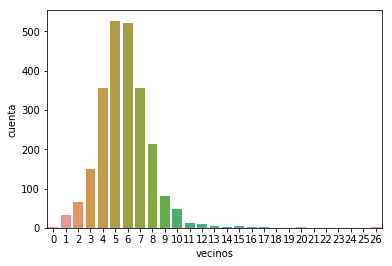

In [33]:
%matplotlib inline
import seaborn as sns

sns.barplot(x='vecinos', y='cuenta', data=freqs)

## Intensidad

Después de este intermedio, ahora sí vamos a hacer nuestro primer cómputo en vecindades. Vamos a comenzar por la **intensidad**.

La intensidad es simplemente la cantidad de actividades en un área determinada. En nuestro caso, vamos a calcular el total de actividades (de cualquier tipo) que hay en la vecindad inmediata de cada AGEB (si lo piensan un poco, esto se parece bastante a los filtros tipo _blur_ en procesamiento de imágenes).

Para calcular la _intensidad_, lo que necesitamos hacer es recorrer la lista de elementos del GeoDataFrame y, para cada elemento, obtener la lista de vecinos, sacar sus variables y sumarlas.

Antes de calcular, vamos a eliminar el elemento que no tiene ningún vecino, reindexar los datos y volver a calcular los pesos (para que los índices de la mátriz de pesos y del DataFrame coincidan):

In [43]:
usos_suelo = usos_suelo.drop(usos_suelo.index[[1224]])
usos_suelo.reset_index(drop=True, inplace=True)
w = pysal.weights.Queen.from_dataframe(usos_suelo)

Ahora sí, recorremos la lista de vecinos y calculamos la intensidad para cada elemento:

In [37]:
usos_suelo.iloc[[0]][['clase_comercio', 'clase_ocio', 'clase_oficinas']].as_matrix()

array([[ 68.,  24.,   6.]])

In [45]:
import numpy as np

intensidad =[]
for i in range(0, w.n):
    vecinos = w.neighbors[i]
    total = 0.0
    suma = np.zeros((3),dtype=np.float)
    valores = usos_suelo.iloc[[i]][['clase_comercio', 'clase_ocio', 'clase_oficinas']].as_matrix()
    for j in range(0,len(vecinos)):    
        data = usos_suelo.iloc[[j]][['clase_comercio', 'clase_ocio', 'clase_oficinas']].as_matrix()
        suma = suma + data
        total += sum(data)
    intensidad.append((i, sum(total)))

print(intensidad[0:10])

[(0, 136.0), (1, 193.0), (2, 193.0), (3, 98.0), (4, 238.0), (5, 98.0), (6, 803.0), (7, 687.0), (8, 238.0), (9, 335.0)]


Al parecer lo que estamos haciendo es muy complicado, sin embargo, una vez más, si lo vemos con detenimiento es relativamente simple:

* Primero estamos definiendo una lista vacía `intensidad` que nos va a servir para guardar los resultados
* Luego, en el **for** externo, estamos recorriendo la matriz de adyacencia, entonces el índice del **for**, es el identificador de cada polígono
* Inicializamos un _array_ de 3 entradas con zeros (esto nos va a servir para guardar la suma para cada uso de suelo)
* Con _iloc_ tomamos la fila correspondiente en el dataframe y _as_matrix()_ convierte los valores de las columnas en un _array_
* Recorremos en el **for** interno los vecinos de cada elemento y tomamos, como _array_, sus valores
* Sumamos los _arrays_ entrada por entrada (esto realmente no es necesario aquí, pero va a ser útil más adelante cuando hagamos un cálculo más complejo)
* A la salida de los dos **for**, agregamos a la lista _intensidad_ una _tupla_ con el índice y el valor de la intensidad

Entonces, podemos convertir la lista _intensidad_ en un DataFrame para después unirlo con nuestros datos:

In [47]:
intensidad_df = pd.DataFrame(intensidad, columns=['gid', 'intensidad'])
datos_intensidad = usos_suelo.merge(intensidad_df, left_index=True, right_on='gid', how='inner')
datos_intensidad.head()

,CVEGEO,geometry,clase_comercio,clase_ocio,clase_oficinas,gid,intensidad
0,0900200010010,"POLYGON ((2792673.308524352 837911.4750908648,...",68.0,24.0,6.0,0,136.0
1,0900200010025,"POLYGON ((2793350.822773742 837765.3497706538,...",27.0,11.0,0.0,1,193.0
2,090020001003A,"POLYGON ((2792311.17880615 837633.5167797694, ...",44.0,11.0,2.0,2,193.0
3,0900200010044,"POLYGON ((2792448.206535 837485.6465441301, 27...",38.0,7.0,0.0,3,98.0
4,0900200010097,"POLYGON ((2792415.238538118 836846.39013781, 2...",27.0,12.0,1.0,4,238.0


### Ejercicio

Hagan un mapa que destaque las diferencias en intensidad

## Entropía

La entropía es una medida de la mezcla de usos de suelo, está basada en la forma en la que se calcula la entropía en mecánica estadística:

$$ E = \sum\limits_{j}{\frac{p_{j}*ln(p_{j})}{ln(J)}} $$

Donde $p_{j}$ representa la proporción del $j-esimo$ uso de suelo con respecto al total y $J$ es el número de usos de suelo considerados. Valores cercanos a 0 indican poca mezcla de usos de suelo y valores cercanos a -1 indican una mezcla balanceada

Entonces, para calcular la entropía, basta con modificar un poco el **for** que usamos para calcular la intensidad:


In [52]:
entropia =[]
for i in range(0, w.n):
    vecinos = w.neighbors[i]
    total = 0.0
    suma = np.zeros((3),dtype=np.float)
    valores = usos_suelo.iloc[[i]][['clase_comercio', 'clase_ocio', 'clase_oficinas']].as_matrix()
    for j in range(0,len(vecinos)):    
        data = usos_suelo.iloc[[j]][['clase_comercio', 'clase_ocio', 'clase_oficinas']].as_matrix()
        suma = suma + data
        total += np.sum(data)
    p = np.nan_to_num(suma/total)
    lp = np.select([p == 0,p > 0],[p, np.log(p)])
    entropia.append((i, np.sum(p*lp)))

print(entropia[0:10])

[(0, -0.73761044698936673), (1, -0.7101258714069415), (2, -0.7101258714069415), (3, -0.76914734912267102), (4, -0.66874333578379019), (5, -0.76914734912267102), (6, -0.63675151842007982), (7, -0.65449672906648715), (8, -0.66874333578379019), (9, -0.66775970276322294)]


La forma de calcular es muy parecida a la _intensidad_ pero aquí hacemos uso de dos funciones extra de _numpy_:

* `np.nan_to_num` convierte en 0 los Valores NaN (resultado de dividir por 0). Esto es necesario en caso de que hubiera AGEBS con 0 usos de suelo
* `np.select([p == 0,p > 0],[p, np.log(p)])` selecciona, en caso de que el valor sea 0, deja el cero, pero si el valor es mayor que 0, entonces calcula el logaritmo (recuerden que el logaritmo de 0 no está definido)

### Ejercicio

Hagan mapas de entropía

## Tarea

Repitan todo el taller para un área metropolitana que escojan. Es necesario que hagan lo siguiente:

* Extraer AGEBS y puntos del DENUE pra el área que escojan (lo pueden hacer en Arc o QGis)
* Clasificar sus propios usos de suelo, es necesario que cambien las definiciones que usamos en el taller
* Calcular intensidad y entropía

La tarea se entrega de la siguiente forma:

Una carpeta en zip con el código (en el formato de esta libreta) y los datos necesarios para correrlo. La tarea se acredita si el código corre.